# Quantum image compression
In this notebook, we simulate the quantum image compression algorithm discussed in [arXiv:2306.09323](https://arxiv.org/abs/2306.09323). We first vectorize and encode a digital greyscale image in a multiqubit circuit. We present an algorithm that downscales the original image resolution to reduce the number of encoding qubits. The simulation is performed with Qiskit Aer.  

In [1]:
# Uncomment in Google Colab
# !pip install qiskit
# !pip install qiskit_aer
# !git clone https://www.github.com/simoneroncallo/quantum_jpeg.git
# %cd /content/quantum_jpeg 
# !mkdir ./output/plots

In [2]:
# === Packages === #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from itertools import product
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT

## Preparation
We load a digital image as matrix $I$, eventually converted to greyscale.

In [3]:
def rgb2gray(rgb):
    """ Convert an RGB digital image to greyscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

We define a function that eventually performs grey levels quantization, allowing to eventually downscale the input image to $c$-bit depth.

### Vectorization

We write a _vectorization_ function, which maps the $M_r \times M_c$ matrix to a $M_r M_c$ column vector $v$, whose components are normalized to the total brightness of the image, i.e. to the sum of each pixel value $\sum_{ij}I_{ij}$, taken under the square root, so that
$$
 I_{ij} \xrightarrow[]{vectorization} v_k \xrightarrow[]{normalization} c_k = \sqrt{\frac{v_k}{\sum_{ij}I_{ij}}} \ .
$$
Vectorization is the key for representing an image as a $n$-qubit quantum state
$$
    |\psi\rangle = \sum_{k=0}^{2^n-1} c_k |k\rangle \ ,
$$
where each pixel value is mapped to the amplitude of the $k$th component of $|\psi\rangle$, with $n = \log_2(M_rM_c)$.

Parallelization is also possible: the image can be split into $S$ equal-sized sectors of dimension $C_r \times C_c$ (called _patches_) each of them vectorized into multiple quantum states as above, with $S = M_r/C_r = M_c/C_c$. In this case, the normalization of each patch is saved for the final reconstruction (to ensure brightness consistency in the final result). For single-patch representations, i.e. when the image is represented by only one quantum state, this information is not necessary.

In [4]:
def vectorization(img, Cr, Cc, renorm = False):
    """ Vectorize the image as follows. 
        1. Split the original (Mr, Mc) image into S equal-sized patches of 
            shape (Cr, Cc). Then, vectorize each patch and collect all 
            in a (S, Cr*Cc) array, called "vect_patches".
        2. Normalize each (Cr*Cc) vector to the intensity of the corresponding 
            (Cr, Cc) patch. When "renorm" is set to True, save the 
            normalization constants in the array "norm" for final decoding. 
            Otherwise, erase this information by setting "norm" equal to an 
            array of 1s.
        3. Define an array called "states" with shape (S, Cr*Cc), obtained as 
            the elementwise square root of "vect_patches".
    Return the couple (states, norm). """
    
    Mr, Mc = img.shape # Shape of the original image (#rows, #columns)
    
    # The image is split into N patches, each of shape (Cr,Cc)
    patches =  (img.reshape(Mc//Cr, Cr, -1, Cc).swapaxes(1, 2)\
                .reshape(-1, Cr, Cc)) # Shape (S, Cr, Cc)
    
    # Vectorization
    vect_patches = np.reshape(patches,\
                              (patches.shape[0],Cr*Cc)) # Shape (S, Cr*Cc)
    
    # Normalization
    states = np.zeros((patches.shape[0],Cr*Cc)) # Shape (S, Cr*Cc)
    
    norm = np.zeros(patches.shape[0]) # Shape (S, 1)
    for idx in range(patches.shape[0]):
        norm[idx] = vect_patches[idx].sum()
        if norm[idx] == 0:
            raise ValueError('Pixel value is 0') 
        tmp = vect_patches[idx]/norm[idx]
        states[idx] = np.sqrt(tmp)
    if renorm == False:
        norm = np.ones(patches.shape[0])
        
    return (states, norm)

### Circuit definitions and encoding
For simplicity, we consider square images only, i.e. with $M := M_r = M_c$.

Our protocol uses the quantum Fourier transform (QFT), which import directly from the Qiskit circuit library. The QFT and IQFT circuits basically works as follows.

### Compression algorithm
At the output of _vectorization_, the image $I$ is split into $S$ column vectors, each represented by a quantum states. 

For each state, we prepare a $n_0$-qubit circuit with $n_i = 2 \log_2(M)$. The algorithm that compresses each patch in $n_{2} = n_0 - 2\tilde{n}$ qubits reads as follows:
1. Apply QFT on the $n_0$-register   
2. Appply IQFT on the first $\tilde{n}$ qubits, which define th $n_1$-register with $n_1 = n_0 - \tilde{n}$ (Rule 1)
3. Discard $\tilde{n}$ qubits from the middle of the register (Rule 2)
4. Measure the remaining $n_2$ qubits

This is implemented by the function *circuit_builder*.

In [5]:
def circuit_builder(states, n0, n2):
    """ Create a list of n-qubit quantum circuits "qcs", each initialized 
    using the array "states". For each circuit
        1. Perform QFT
        2. Apply IQFT on the first (n0 - n2)//2 qubits
        3. Discard (n0 - n2)//2 qubits from the middle of the register, then 
            perform a measurement of the remaining qubits and store the 
            results in a classical register of n2 bits 
    Return "qcs". """
    
    ntilde = (n0 - n2)//2 # Total number of qubits removed aat each Step
    n1 =  n0 - ntilde # Number of qubits kept, before IQFT is applied
    
    qcs = []
    for idx in range(states.shape[0]):
        q = QuantumRegister(n0)
        c = ClassicalRegister(n2)
        qc = QuantumCircuit(q,c)
        
        qc.initialize(states[idx], q)    
        
        qc.h(q) # Optional, improves the reconstruction
        
        # Apply QFT on the full circuit
        qc.compose(QFT(num_qubits=n0, approximation_degree=0, do_swaps=True, \
                       inverse=False, insert_barriers=True, name='QFT'), \
                       inplace = True)
        
        qc.barrier()
        
        # Apply IQFT on the first n1 qubits (Rule 1)
        qc.compose(QFT(num_qubits=n1, approximation_degree=0, do_swaps=True, \
                       inverse=True, insert_barriers=True, name='IQFT'), \
                       qubits = q[0:n1], inplace = True)
        
        creg_idx = 0
        for idx in range(n1):  
            if n0//2 - ntilde <= idx <= n0//2 - 1: 
                continue # Qubit discarded from the measurement (Rule 2)
            qc.h(q[idx]) # Optional, improves the reconstruction
            qc.measure(q[idx],c[creg_idx])
            creg_idx += 1
        qcs.append(qc)
        
    return qcs

The _reconstruction_ function simulates the above circuits, gathering the statistics and reconstructing an array of $S$ vectors, each with $2^{n_2}$ frequencies describing the output of the corresponding circuit.

In [6]:
def reconstruction(qcs, n2, shots, norm):
    """ Simulate "qcs" with a given number of "shots". 
    Return an array "out_freq" with shape (S, 2**n2), describing the output 
    frequencies of each circuit and eventually rescaled using the corresponding
    component of "norm". """
    
    out_freq = np.zeros((len(qcs), 2**n2)) # Shape (S, 2**n2)
    
    for idx in range(len(qcs)):
        simulator = AerSimulator()
        qcs[idx] = transpile(qcs[idx], simulator)
        result = simulator.run(qcs[idx], shots = shots).result()
        
        counts = result.get_counts(qcs[idx]) # Counts at the output of qcs[idx]
        tot = sum(counts.values(), 0.0)
        prob = {key: val/tot for key, val in counts.items()} # Frequencies
        
        out = np.zeros(2**n2) # Shape (1, 2**n2)
        
        # Generate all the possible n2 qubits configurations
        cfgs = list(product(('0','1'), repeat = n2))
        cfgs = [''.join(cfg) for cfg in cfgs] 
        for i in range(2**n2):
            out[i] = prob.get(cfgs[i], 0)
            
        out_freq[idx,:] = out[:]*norm[idx]
    
    return out_freq

The function _devectorization_ reconstructs the compressed image from the output of the simulated circuits, by first inverting the vectorization and then recombining the patches.

In [7]:
def devectorization(out_freq):
    """ Reconstruct an image using the simulation output. The function 
    operates as follows:
        1. Devectorize each of the S arrays in "out_freq" to 
            a (2**(n2/2), 2**(n2/2)) patch.
        2. Recombine the patches in a single object called "decoded_img" with 
        shape (Mr, Mc). 
    Return an image with number of pixels equal to the length of "out_freq" 
    times the number of patches. """
    
    S = out_freq.shape[0] # Number of patches
    nrow = int(np.sqrt(out_freq.shape[1])) # Number of rows of each patch
    ncol = nrow # Number of columns of each compressed patch
    
    decoded_patches = np.reshape(out_freq,\
                      (out_freq.shape[0], nrow, ncol)) # Shape (S, nrow, ncol)
    
    im_h, im_w = nrow*int(np.sqrt(S)), ncol*int(np.sqrt(S)) # Final shape
    
    decoded_img = np.zeros((im_w, im_h)) # Initialization
    
    idx = 0
    for row in np.arange(im_h - nrow + 1, step=nrow):
        for col in np.arange(im_w - ncol + 1, step=ncol):
            decoded_img[row:row+nrow, col:col+ncol] = decoded_patches[idx]
            idx += 1
            
    return decoded_img

## Simulation
We now execute the algorithm on a specific image example. 

The resolution is 512 x 512 pixels. There are 262144 pixels.


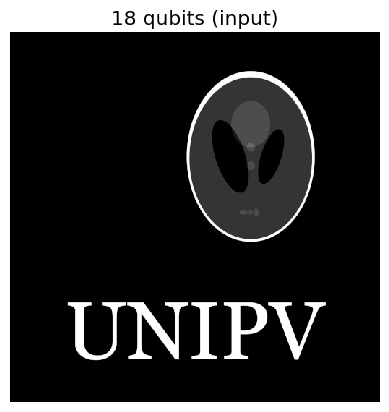

In [8]:
img = mpimg.imread('input/input1.jpg') # Load the input image
# img = np.array(list(zip(*img[::-1]))) # Rotate the image

if len(img.shape) != 2:
    img = rgb2gray(img) # Convert an RGB image to greyscale
    
bitdepth = 8 # Depth
black, white = 0, 2**bitdepth - 1

plt.rcParams.update({'font.size': 12})
# plt.rcParams['figure.figsize'] = [4, 4] # Resize the output canvas

Mr, Mc = img.shape
print('The resolution is', Mr, 'x', Mc, 'pixels.',\
      'There are', np.size(img), 'pixels.')

# np.savetxt('output/data/input' + str(int(np.log2(Mr*Mc)))\
#           + 'q' + '.txt', img, fmt='%u') # Save
# np.save('output/data/input' + str(int(np.log2(Mr*Mc)))\
#                   + 'q' + '.npy', img) # Save

plt.imshow(img, cmap='gray', vmin = black, \
           vmax = white, interpolation = 'none')
    
plt.title('%i qubits (input)' %np.log2(Mr*Mc))
plt.axis('off')
filename = 'output/images/input' + str(int(np.log2(Mr*Mc))) + 'q' + '.png'

# Save
# plt.savefig(filename, bbox_inches='tight') # Upscale
# plt.imsave(fname=filename, arr=img, cmap='gray', \
#           vmin = black, vmax = white, format='png') # Faithful

plt.show()

In [9]:
Cr,Cc = Mr, Mc
states, norm = vectorization(img, Cr, Cc)
n0 = int(np.log2(Cr*Cc)) # Number of qubits for each circuit

print('The shape of the vectorized image is ', states.shape,\
      '. It will be loaded in ', states.shape[0],\
          ' circuit(s) of ' , n0, ' qubits.', sep='')

The shape of the vectorized image is (1, 262144). It will be loaded in 1 circuit(s) of 18 qubits.


### Compression

We simulate the compression for different numbers of output qubits. The higher the number of discarded qubits is, the lower is the resolution of the output image.

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

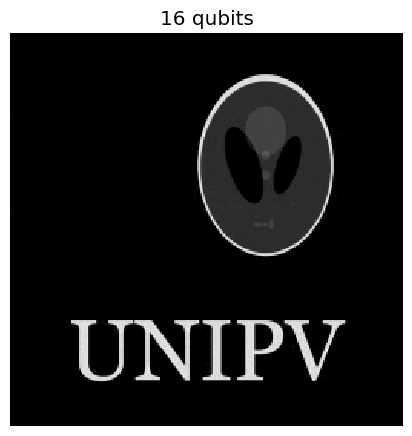

 12%|██████████▌                                                                         | 1/8 [00:28<03:21, 28.81s/it]

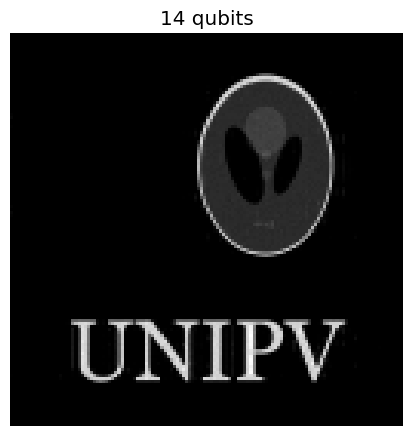

 25%|█████████████████████                                                               | 2/8 [00:38<01:44, 17.49s/it]

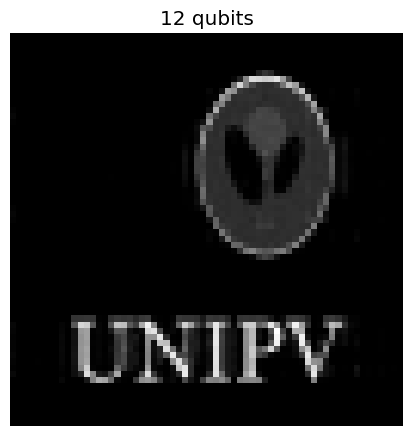

 38%|███████████████████████████████▌                                                    | 3/8 [00:42<00:57, 11.46s/it]

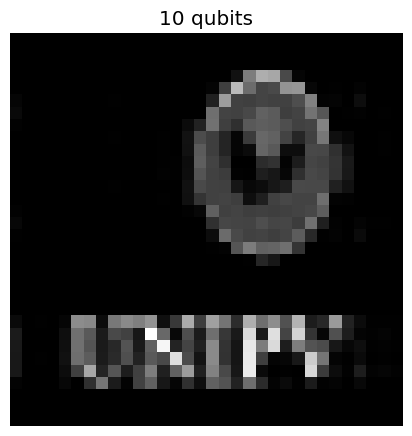

 50%|██████████████████████████████████████████                                          | 4/8 [00:45<00:32,  8.11s/it]

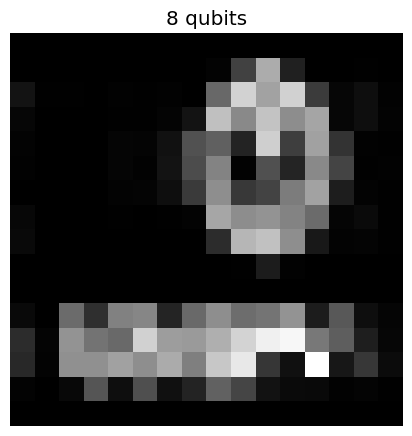

 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:48<00:18,  6.13s/it]

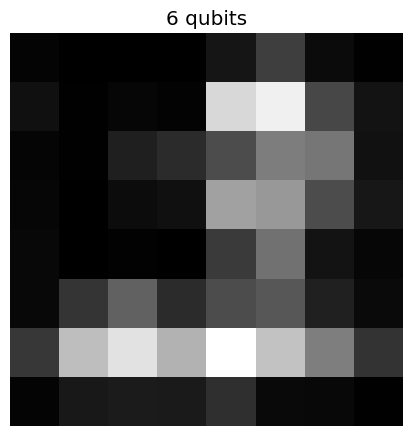

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:50<00:09,  4.96s/it]

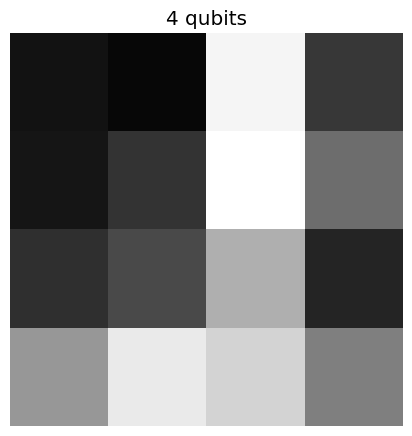

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:53<00:04,  4.22s/it]

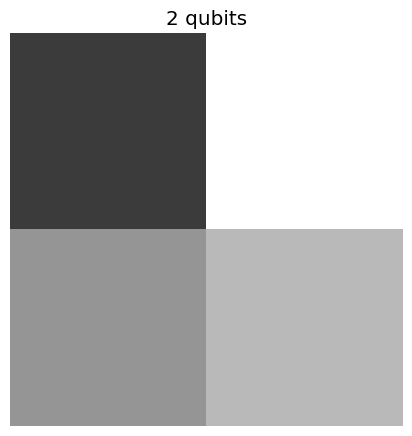

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:56<00:00,  7.05s/it]


In [10]:
for n2 in tqdm(range(n0-2, 0, -2)):
    # Choices of shots = 
    # 2**(n2+2*bitdepth)                           Ideal,
    # 2**(n2+bitdepth)*int(np.sqrt(2**bitdepth))   Standard
    # 2**(n2+bitdepth)                             Reasonable
    # 2**(n2)*16                                   Noisy                                                      
    shots = 2**(n2+bitdepth)
    
    states, norm = vectorization(img, Cr, Cc)
    qcs = circuit_builder(states, n0, n2)
    out_freq = reconstruction(qcs, n2, shots, norm)
    final_img = devectorization(out_freq)*shots
    
    black, white = 0, 2**bitdepth - 1 
    final_img = final_img/final_img.max()*white
    
    # np.savetxt('output/data/output' + str(n2)\
    #           + 'q' + '.txt', final_img,fmt='%u') # Save
    # np.save('output/data/output' + str(n2)\
    #               + 'q' + '.npy', final_img) # Save
    
    plt.imshow(final_img, cmap='gray', vmin = black, vmax = white,\
               interpolation = 'none')
    
    plt.title('%i qubits' %n2)
    plt.tight_layout()
    plt.axis('off')
    
    # Save
    filename = 'output/images/output' + str(n2) + 'q' + '.png' 
    # plt.savefig(filename, bbox_inches='tight') # Upscale
    # plt.imsave(fname=filename, arr=final_img, cmap='gray', \
    #           vmin = black, vmax = white, format='png') # Faithful
        
    plt.show()

### Statistical considerations
We now estimate the grey values fluctutations for each pixel, for $n_2 = 14$.

To do so, we repeat the compression algorithm for a certain amount of times. Then, we calculate the standard deviation at each pixel location.

In [11]:
trials = 20 # The number of compressed images in the sample
n2 = 14

final_images = np.zeros((trials,2**(n2)))

states, norm = vectorization(img, Cr, Cc)
qcs = circuit_builder(states, n0, n2)

In [12]:
print('Standard deviation estimation...')

for idx in tqdm(range(trials)): 
    shots = 2**(n2) # We keep a low number of shots, to expliclty highlight the presence of statistical fluctuations

    out_freq = reconstruction(qcs, n2, shots, norm)
    final_img = devectorization(out_freq)*shots

    black, white = 0, 255
    final_img = final_img/final_img.max()*white
        
    final_images[idx,:] = np.reshape(final_img, 2**n2)
    
stds = np.std(final_images, axis=0)

Standard deviation estimation...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:45<00:00,  2.28s/it]


We plot a histogram that shows the number of pixels with respect to their standard deviation. The inset shows the standard deviation at each pixel location.

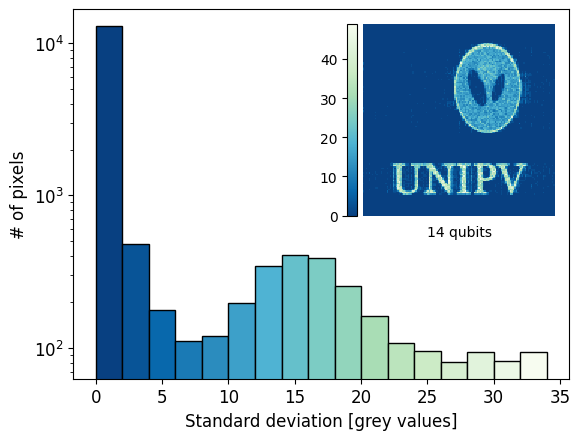

In [13]:
fig, ax1 = plt.subplots()
cmap = plt.cm.GnBu_r

bins = np.arange(0,35,2)
# bins = np.arange(0,4.5,0.5) # Uncomment when Hadamard is off
h_n, h_bins, h_patches = ax1.hist(stds, bins = bins, edgecolor='black', linewidth = 1)
plt.yscale('log',base=10)

# Set the color of each bin, accordingly to the value plotted in the inset
bin_centers = 0.5 * (h_bins[:-1] + h_bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, h_patches):
    plt.setp(p, 'facecolor', cmap(c))
    
# ax1.set_xlim([-0.5, 6.5]) # Uncomment when Hadamard is off
ax1.set_xlabel('Standard deviation [grey values]')
ax1.set_ylabel('# of pixels')

# Plot the inset
left, bottom, width, height = [0.508, 0.45, 0.4, 0.40]
ax2 = fig.add_axes([left, bottom, width, height])

stds_mtx = np.reshape(stds, (2**(n2//2), 2**(n2//2)))
cax = ax2.matshow(stds_mtx, cmap=cmap, interpolation = 'none')
ax2.axis('off')
ax2.set_title(str(n2) + ' qubits', fontsize=10, y=-0.15)
cbar = fig.colorbar(cax, location='left', pad= 0.025)
cbar.ax.tick_params(labelsize=10)

# plt.savefig("output/plots/StatisticalFluctuations.pdf", format="pdf")
plt.show()